#  Semantic segmentation by Fully Convolutional DenseNet56 with Keras2.0

###  This is my experiment to see how Fully Convolutional DenseNet56 works with little data

For theory and algorithm. please refer to "The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation (Simon Jegou, Michal Drozdzal, David Vazquez, Adriana Romero, Yoshua Bengio),  5 Dec 2016" 
https://arxiv.org/abs/1611.09326

Origingal code in fast.ai by Jeremy Howard is provided with this link. I rewrite it with keras2 and modify https://github.com/fastai/courses/blob/master/deeplearning2/tiramisu-keras.ipynb 

For data, http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/
Segmentation and Recognition Using Structure from Motion Point Clouds, ECCV 2008 Brostow, Shotton, Fauqueur, Cipolla

In [2]:
import os
import h5py
import numpy as np
import tensorflow as tf
import time
import glob
import json
import csv
import bcolz
import threading
import random
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import keras
from keras import applications
from keras.preprocessing import image

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Cropping2D,BatchNormalization,Conv2DTranspose
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda, GlobalAveragePooling2D, Reshape
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential

from keras.engine import Input
from keras.layers.merge import concatenate
from keras.layers.pooling import AveragePooling2D
from keras.regularizers import l2
from keras.utils import np_utils
from keras.optimizers import SGD

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

import os

## 1. Data preparation

CamVid., sciene-images data set, is used. 

In [3]:
PATH='camvid/'

### 1.1  Read name of images

In [4]:
frames_path = PATH+'701_StillsRaw_full/'

In [5]:
labels_path = PATH+'LabeledApproved_full/'

In [6]:
fnames = glob.glob(frames_path+'*.png')

In [7]:
lnames = [labels_path+os.path.basename(fn)[:-4]+'_L.png' for fn in fnames]

In [8]:
img_sz = (480,360)

In [9]:
def open_image(fn): 
    return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

In [10]:
img = Image.open(fnames[0]).resize(img_sz, Image.NEAREST)

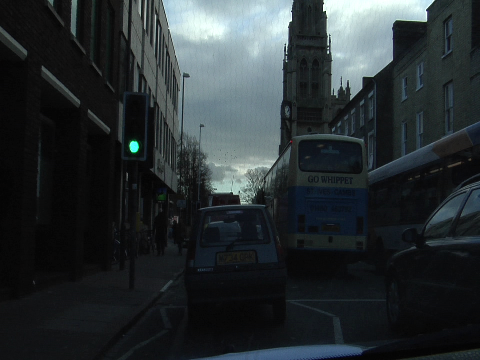

In [11]:
img

### 1.2 Load images

In [12]:
imgs = np.stack([open_image(fn) for fn in fnames])

In [13]:
labels = np.stack([open_image(fn) for fn in lnames])

In [14]:
imgs.shape,labels.shape

((701, 360, 480, 3), (701, 360, 480, 3))

### 1.3 Save array 

In [15]:
def save_array(fname, arr):
    base_dir = os.path.dirname(fname)
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname): 
    return bcolz.open(fname)[:]

In [16]:
#Normalize pixel values
imgs=imgs/255.

In [17]:
save_array(PATH+'results/imgs.bc', imgs)
save_array(PATH+'results/labels.bc',labels)

In [18]:
imgs = load_array(PATH+'results/imgs.bc')
labels = load_array(PATH+'results/labels.bc')

### 1.4 Standardize values of image data

In [19]:
av=np.mean(imgs)
sd=np.std(imgs)
av,sd

(0.39996644266360826, 0.3017949114229091)

In [20]:
imgs-=av
imgs/=sd

In [21]:
n,r,c,ch = imgs.shape

In [22]:
print(n, r, c, ch)

701 360 480 3


## 2.Data Preprocessing

### 2.1 Data generator

This implementation employs data augmentation on CamVid. 

Augmentation includes random cropping / horizontal flipping, as done by `segm_generator()`. `BatchIndices()` lets us randomly sample batches from input array.

In [23]:
class BatchIndices(object):
    """
    n: number of samples
    bs: batch size
    """
    def __init__(self, n, bs, shuffle=False):
        self.n, self.bs, self.shuffle = n, bs, shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: 
                self.reset()
            ni = min(self.bs, self.n - self.curr)
            res = self.idxs[self.curr : self.curr + ni]
            self.curr += ni
            return res

In [24]:
np.random.permutation(3)

array([2, 0, 1])

In [25]:
bi = BatchIndices(12,3)
[next(bi) for o in range(5)]

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8]),
 array([ 9, 10, 11]),
 array([0, 1, 2])]

In [26]:
bi = BatchIndices(15,3,True)
[next(bi) for o in range(5)]

[array([10,  0,  8]),
 array([ 6, 12,  5]),
 array([1, 3, 9]),
 array([ 7, 13,  2]),
 array([14,  4, 11])]

In [82]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        """
        x: images(n_samples, height, width, channels)
        y: labels
        bs: batch size
        out_sz: output size
        train: True for training, False for other stages.
        """
        self.x, self.y, self.bs, self.train = x, y, bs, train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            # horizontal flipping
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        #return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)
        return np.stack(xs), np.stack(ys)

As an example, here's a crop of the image.

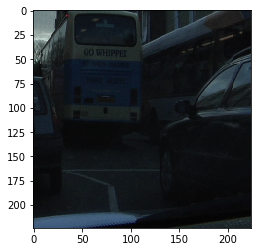

In [28]:
sg = segm_generator(imgs, labels, 4, train=False)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

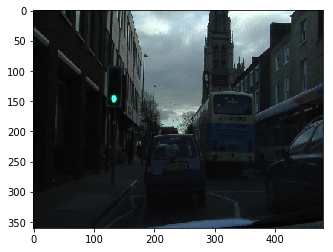

In [29]:
plt.imshow(imgs[0]*0.3+0.4);

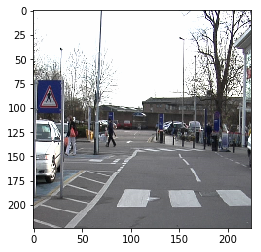

In [30]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

### 2.2 Convert labels

The following loads, parses, and converts the segment labels we need for targets.

In particular we're looking to make the segmented targets into integers for classification purposes.

Each segment / category is indicated by a particular color. The following maps each unique pixel to it's category.

In [31]:
for l in open(PATH+"label_colors.txt"):
    aa = l[:-1].split("\t")
    a=aa[0]
    b=aa[1]
    print(aa)

['64 128 64', 'Animal']
['192 0 128', 'Archway']
['0 128 192', 'Bicyclist']
['0 128 64', 'Bridge']
['128 0 0', '', 'Building']
['64 0 128', 'Car']
['64 0 192', 'CartLuggagePram']
['192 128 64', 'Child']
['192 192 128', 'Column_Pole']
['64 64 128', 'Fence']
['128 0 192', 'LaneMkgsDriv']
['192 0 64', 'LaneMkgsNonDriv']
['128 128 64', 'Misc_Text']
['192 0 192', 'MotorcycleScooter']
['128 64 64', 'OtherMoving']
['64 192 128', 'ParkingBlock']
['64 64 0', '', 'Pedestrian']
['128 64 128', 'Road']
['128 128 192', 'RoadShoulder']
['0 0 192', '', 'Sidewalk']
['192 128 128', 'SignSymbol']
['128 128 128', 'Sky']
['64 128 192', 'SUVPickupTruck']
['0 0 64', '', 'TrafficCone']
['0 64 64', '', 'TrafficLight']
['192 64 128', 'Train']
['128 128 0', 'Tree']
['192 128 192', 'Truck_Bus']
['64 0 64', '', 'Tunnel']
['192 192 0', 'VegetationMisc']
['0 0 0', '', 'Void']
['64 192 0', 'Wall']


In [32]:
def parse_code(l):
    aa = l.strip().split('\t')
    a,b = [a_ for a_ in aa if len(a_) != 0]
    return tuple(int(o) for o in a.split(' ')), b

In [33]:
label_codes,label_names = zip(*[parse_code(l) for l in open(PATH+"label_colors.txt")])

In [34]:
label_codes,label_names = list(label_codes),list(label_names)

We're going to map each unique pixel color to an integer so we can classify w/ our NN

In [35]:
code2id = {v:k for k,v in enumerate(label_codes)}
for i, (k, v) in enumerate(code2id.items()):
    if i < 10:
        print(k, v)
    else:
        break

(64, 128, 64) 0
(192, 0, 128) 1
(0, 128, 192) 2
(0, 128, 64) 3
(128, 0, 0) 4
(64, 0, 128) 5
(64, 0, 192) 6
(192, 128, 64) 7
(192, 192, 128) 8
(64, 64, 128) 9


We'll include an integer for erroneous pixel values.

In [36]:
failed_code = len(label_codes)+1

In [37]:
label_codes.append((0,0,0))
label_names.append('unk')

In [38]:
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[tuple(labels[i,j,k])]
            except: res[j,k] = failed_code
    return res

In [39]:
from concurrent.futures import ProcessPoolExecutor

In [40]:
def conv_all_labels():
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(conv_one_label, range(n)))

Now we'll create integer-mapped labels for all our colored images.

### labels_int variable have label index in each pixel

In [41]:
%time labels_int =conv_all_labels()

CPU times: user 660 ms, sys: 547 ms, total: 1.21 s
Wall time: 9min 48s


In [42]:
np.count_nonzero(labels_int==failed_code)

44

Set erroneous pixels to zero.

In [43]:
labels_int.shape

(701, 360, 480)

In [44]:
labels_int[labels_int==failed_code]=0

In [45]:
save_array(PATH+'results/labels_int.bc', labels_int)

In [46]:
labels_int = load_array(PATH+'results/labels_int.bc')

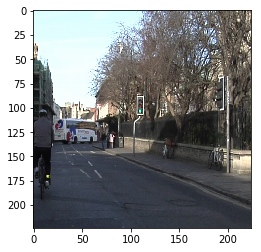

In [47]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

Here is an example of how the segmented image looks.

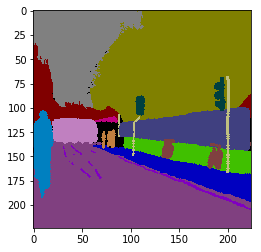

In [48]:
plt.imshow(b_label[0].reshape(224,224,3));

### 2.3 Split training set and test set

Next we load test set, set training/test images and labels.

In [49]:
trn = imgs[0:468]
trn_labels = labels_int[0:468]
test = imgs[468:701]
test_labels = labels_int[468:701]
trn.shape, trn_labels.shape, test.shape, test_labels.shape

((468, 360, 480, 3), (468, 360, 480), (233, 360, 480, 3), (233, 360, 480))

In [50]:
rnd_trn = len(trn_labels)
rnd_test = len(test_labels)

## 3. Build "Fully Convolutional DenseNet56 "

### 3.1 Helper functions

In [51]:
import tensorflow as tf

In [52]:
def relu(x): 
    return tf.nn.relu(x)
def dropout(x, p): 
    return tf.nn.dropout(x, keep_prob=p) if p else x
def bn(x): 
    return tf.layers.batch_normalization(x, axis=-1)
def relu_bn(x): 
    return relu(bn(x))
def concat(xs): 
    return tf.concat(xs, axis=-1)

In [65]:
def conv(x, nf, sz, wd, p, stride=1): 
    """
    x: input tensor
    nf: number of filters
    sz: filter size
    wd: regularization factor
    """
    x = tf.layers.conv2d(x, nf, sz, strides=(stride, stride), padding='SAME', 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(),
                         kernel_regularizer=tf.contrib.layers.l2_regularizer(wd))
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

Recall the dense block from DenseNet.

In [54]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

This is the downsampling transition. 

In the original paper, downsampling consists of 1x1 convolution followed by max pooling. However we've found a stride 2 1x1 convolution to give better results.

In [55]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

Next we build the entire downward path, keeping track of Dense block outputs in a list called `skip`. 

In [56]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

This is the upsampling transition. We use a transpose convolution layer.

In [67]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return tf.layers.conv2d_transpose(x, ch, (r*2, c*2), strides=(2, 2), padding='SAME',
                                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(wd)
                )
    #return Conv2DTranspose(ch, 3,  kernel_initializer='he_uniform', 
    #           padding='same', strides=(2,2), kernel_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

This builds our upward path, concatenating the skip connections from `skip` to the Dense block inputs.

In [58]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

### 3.2 Build the model

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- nb_dense_block: number of dense blocks to add 
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- nb_layers_per_block: number of layers in each dense block.
  - If positive integer, a set number of layers per dense block.
  - If list, nb_layer is used as provided
- p: dropout rate
- wd: weight decay

In [59]:
def reverse(a): return list(reversed(a))

Finally we put together the entire network.

In [75]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=12, nb_filter=48, nb_layers_per_block=4, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    print(skips)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    #x = Reshape((-1, nb_classes))(x)
    x = tf.reshape(x, (-1, nb_classes))
    #return Activation('softmax')(x)
    return x

## 4. Train the model

### 4.1 Training on argumented images

In [80]:
sess = tf.InteractiveSession()

In [61]:
input_shape = (224,224,3)

In [62]:
#img_input = Input(shape=input_shape)
img_input = tf.placeholder(tf.float32, shape=(None, 224, 224, 3))

In [63]:
from keras.layers import  Input, Dense

In [77]:
logits = create_tiramisu(33, img_input, nb_layers_per_block=4, p=0.2, wd=1e-4)

[<tf.Tensor 'concat_215:0' shape=(?, 224, 224, 96) dtype=float32>, <tf.Tensor 'concat_219:0' shape=(?, 112, 112, 144) dtype=float32>, <tf.Tensor 'concat_223:0' shape=(?, 56, 56, 192) dtype=float32>, <tf.Tensor 'concat_227:0' shape=(?, 28, 28, 240) dtype=float32>, <tf.Tensor 'concat_231:0' shape=(?, 14, 14, 288) dtype=float32>, <tf.Tensor 'concat_235:0' shape=(?, 7, 7, 336) dtype=float32>]


In [ ]:
y = tf.placeholder(tf.int64, shape=(None, 224, 224))
expected = tf.expand_dims(y, [-1])
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(expected, [-1]), logits=logits, name='x_entropy')
loss = tf.reduce_mean(cross_entropy, name='x_entropy_mean')
train_step = tf.train.RMSPropOptimizer(learning_rate=1e-3).minimize(loss)

n_epoch = 1
n_batch = 3
trn_gen = segm_generator(trn, trn_labels, bs=n_batch, train=True)
n_loop = len(trn) // n_batch

sess.run(tf.global_variables_initializer())
for epoch in range(n_epoch):
    for i in range(n_loop):
            trn_img, trn_label = next(trn_gen)
            feed_dict = {img_input: trn_img, y: trn_label}
            l = sess.run([loss], feed_dict=feed_dict)
            print('epoch:', epoch)
            print('loss:', l)

saver = tf.train.Saver()
save_dir = 'models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
saver.save(sess, save_dir + 'tiramisu')
print('Model saved:', save_dir + 'tiramisu')

In [63]:
model = Model(img_input, x)

In [64]:
gen = segm_generator(trn, trn_labels, 3, train=True)

In [65]:
gen_test = segm_generator(test, test_labels, 3, train=False)

In [66]:
model.compile(loss='sparse_categorical_crossentropy',  optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

filepath='tiramisu.{epoch:02d}-{val_acc:.2f}.hdf5'
mc_cb = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

In [67]:
model.optimizer=keras.optimizers.RMSprop(1e-3, decay=1-0.99995)

To obtain accuracy over 85%,  it may take more than 24-48 hours (50-100 epochs) when you use Mac air (without GPU)
Please look at http://www.toshistats.net/deep-learning-blog/2017/8/12/this-is-incredible-semantic-segmentation-by-just-700-images-from-scratch-with-mac-air

In [68]:
batch_size=3
epochs=1

import time
t=time.time()  

history=model.fit_generator(gen, rnd_trn//batch_size,  epochs, verbose=2,
                    validation_data=gen_test, validation_steps=rnd_test//batch_size, callbacks=[mc_cb])

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

model.summary()

Epoch 1/1


KeyboardInterrupt: 

## 5. View results

### 5.1 Import RGB data and names for each class

In [10]:
colors = [(64, 128, 64), (192, 0, 128), (0, 128, 192),(0, 128, 64), (128, 0, 0), (64, 0, 128), (64, 0, 192), (192, 128, 64), (192, 192, 128), (64, 64, 128),
 (128, 0, 192), (192, 0, 64), (128, 128, 64), (192, 0, 192), (128, 64, 64), (64, 192, 128), (64, 64, 0), (128, 64, 128), (128, 128, 192), (0, 0, 192),
(192, 128, 128), (128, 128, 128), (64, 128, 192), (0, 0, 64),(0 ,64, 64), (192, 64, 128), (128, 128, 0), (192, 128, 192), (64, 0, 64),(192, 192, 0),
 (0, 0, 0), (64, 192, 0)]

names = ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car','CartLuggagePram', 'Child', 'Column_Pole','Fence', 'LaneMkgsDriv', 
         'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving','ParkingBlock','Pedestrian','Road', 'RoadShoulder','RoadShoulder',
         'Sidewalk', 'SignSymbol','Sky', 'SUVPickupTruck','TrafficCone', 'TrafficLight','Train','Tree','Truck_Bus', 'Tunnel','VegetationMisc','Void',
         'Wall']

In [12]:
# Import the model created above
from keras.models import load_model
model = load_model('tiramisu.97-0.82.hdf5')

### 5.2 view the result of exmaples

In [64]:
i=3

In [65]:
b = np.expand_dims(b_img[i], axis=0)
print(np.shape(b))

p = model.predict(b)
print(np.shape(p))

p = np.argmax(p[0],-1).reshape(224,224)
print(np.shape(p))

(1, 224, 224, 3)
(1, 50176, 33)
(224, 224)


In [66]:
def color_label(i): 
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            res[j,k,:] = colors[p[j,k]]
    return res

In [67]:
r=224
c=224
pred = color_label(p)

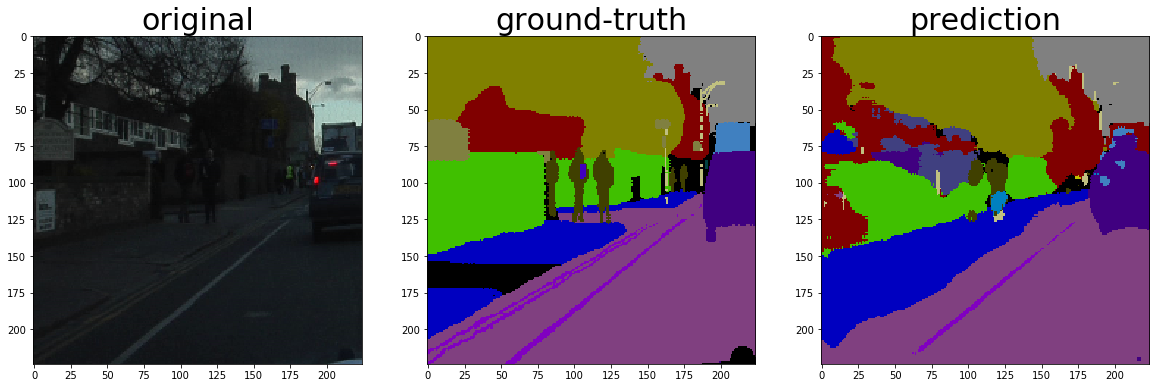

In [68]:
# Show the sample images
bl=b_label[i].reshape(224,224,3)

imm=[(b_img[i]*0.3+0.4), bl, pred]
title=['original','ground-truth','prediction']
plt.figure(figsize=(20,15))

for i in range(len(imm)):
    plt.subplot(1,3, i+1)
    plt.imshow(imm[i]) 
    plt.title(title[i],fontsize=30)

Notice: TOSHI STATS SDN. BHD. and I do not accept any responsibility or liability for loss or damage occasioned to any person or property through using materials, instructions, methods, algorithm or ideas contained herein, or acting or refraining from acting as a result of such use. TOSHI STATS SDN. BHD. and I expressly disclaim all implied warranties, including merchantability or fitness for any particular purpose. There will be no duty on TOSHI STATS SDN. BHD. and me to correct any errors or defects in the codes and the software